# Riskfolio-Lib Tutorial: 
<br><a href="https://www.kqzyfj.com/click-101360347-15150084?url=https%3A%2F%2Flink.springer.com%2Fbook%2F9783031843037" target="_blank">
<div>
<img src="https://raw.githubusercontent.com/dcajasn/Riskfolio-Lib/refs/heads/master/docs/source/_static/Button.png" height="40" />
</div>
<br>
</a>
<a href="https://www.paypal.com/ncp/payment/GN55W4UQ7VAMN" target="_blank">
<div>
<img src="https://raw.githubusercontent.com/dcajasn/Riskfolio-Lib/refs/heads/master/docs/source/_static/Button2.png" height="40" />
</div>
</a>

<br><a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 
<br>
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.linkedin.com/company/orenj-i)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__

## Tutorial 53: Mean Kurtosis Optimization with Risk Factors

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']

assets.sort()

# Tickers of factors

factors = ['MTUM', 'QUAL', 'VLUE', 'SIZE', 'USMV']
factors.sort()

tickers = assets + factors
tickers.sort()

# Downloading data
data = yf.download(tickers, start = start, end = end, auto_adjust=False)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = tickers

[*********************100%***********************]  30 of 30 completed


In [2]:
# Calculating returns

X = data[factors].pct_change().dropna()
Y = data[assets].pct_change().dropna()

display(X.head())

,MTUM,QUAL,SIZE,USMV,VLUE
Date,,,,,
2016-01-05,0.4736%,0.2672%,0.0000%,0.6780%,0.1635%
2016-01-06,-0.5268%,-1.1914%,-0.5380%,-0.6253%,-1.8277%
2016-01-07,-2.2293%,-2.3798%,-1.7181%,-1.6214%,-2.1609%
2016-01-08,-0.9549%,-1.1377%,-1.1978%,-1.0087%,-1.0873%
2016-01-11,0.6043%,0.1480%,-0.5898%,0.1491%,-0.6183%


## 2. Estimating Mean Kurtosis Portfolios

The Kurtosis portfolio model proposed by __[Cajas (2022)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3988927)__ shows how to optimize the fourth moment of portfolio returns in a similar way than portfolio variance. 

It is recommended to use MOSEK to optimize Kurtosis for a large number of assets due the model use semidefinite programming. Also, for a large number of assets is recommended to use the relaxed version of this model based only on second order cone programming. To use the relaxed version we have to use a number of assets higher than the property __n_max_kurt__, so for example if number of assets is 30 and we set __port.n_max_kurt = 25__, riskfolio-lib is going to use the relaxed version.

Instructions to install MOSEK are in this __[link](https://docs.mosek.com/9.2/install/installation.html)__, is better to install using Anaconda. Also you will need a license, I recommend you that ask for an academic license __[here](https://www.mosek.com/products/academic-licenses/)__.

### 2.1 Estimating the loadings matrix

This part is just to visualize how Riskfolio-Lib calculates a loadings matrix.

In [3]:
import riskfolio as rp

step = 'Forward' # Could be Forward or Backward stepwise regression
loadings = rp.loadings_matrix(X=X, Y=Y, stepwise=step)

loadings.style.format("{:.4f}").background_gradient(cmap='RdYlGn')

,const,MTUM,QUAL,SIZE,USMV,VLUE
APA,-0.0006,-0.6551,0.0000,0.9406,-0.7884,1.7237
BA,0.0005,0.0000,1.1744,0.3616,-0.4322,0.0000
BAX,0.0003,0.3146,0.0000,0.0000,0.7717,0.0000
BMY,-0.0003,0.0000,0.8123,0.0000,0.0000,0.0000
CMCSA,0.0001,0.0000,0.4958,0.0000,0.4962,0.0000
CNP,0.0001,-0.5595,-0.2157,0.0000,1.8341,0.0000
CPB,-0.0003,-0.4782,-0.5994,0.0000,2.0793,0.0000
DE,0.0004,0.0000,0.0000,0.3631,0.0000,0.8090
HPQ,0.0002,0.0000,0.0000,0.0000,0.0000,1.2514
JCI,0.0001,0.0000,0.0000,0.3411,0.0000,0.5797


### 2.2 Calculating the portfolio that optimize return/kurtosis ratio

In [4]:
import mosek

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.
method_kurt='hist' # Method to estimate cokurtosis square matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov,
                  method_kurt=method_kurt)

port.factors = X
port.factors_stats(method_mu=method_mu,
                   method_cov=method_cov,
                   method_kurt=method_kurt,
                   higher_comoments=True)

port.solvers = ['MOSEK'] # It is recommended to use mosek when optimizing Kurtosis

# Estimate optimal portfolio:
model ='FM' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'KT' # Risk measure used, this time will be Tail Gini Range
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

You must convert self.kurt to a positive definite matrix
You must convert self.kurt_fm to a positive definite matrix


,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,2.9721%,9.3226%,0.0000%,0.0000%,15.2465%,0.0000%,0.6511%,0.0000%,0.0000%,...,15.1588%,0.0000%,0.0000%,0.0000%,3.4879%,6.9799%,0.0000%,0.0000%,12.8165%,0.0000%


### 2.3 Plotting portfolio composition

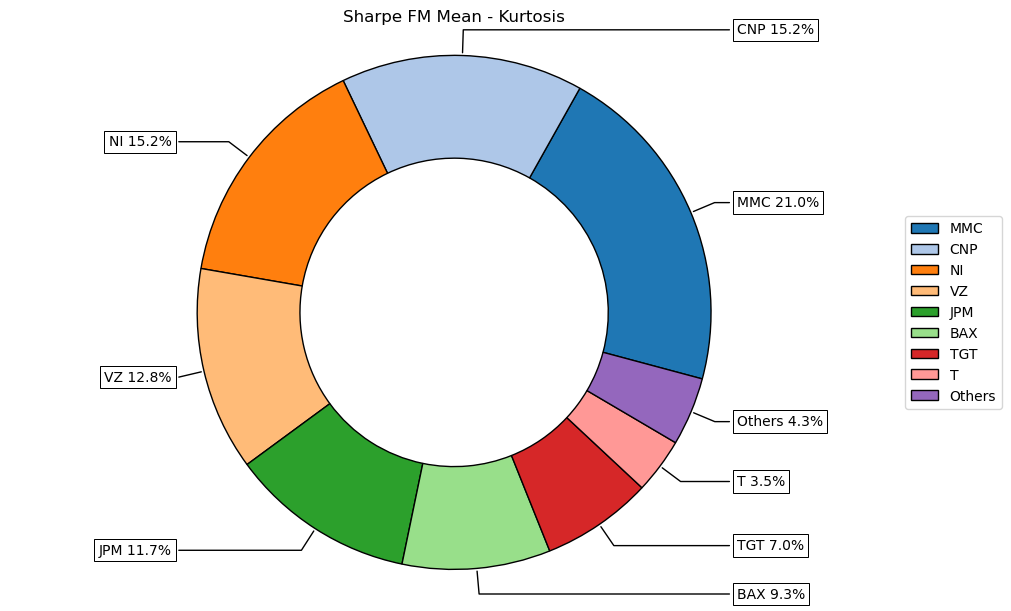

In [5]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='Sharpe FM Mean - Kurtosis',
                 others=0.05,
                 nrow=25,
                 cmap = "tab20",
                 height=6,
                 width=10,
                 ax=None)

### 2.4 Plotting risk measures

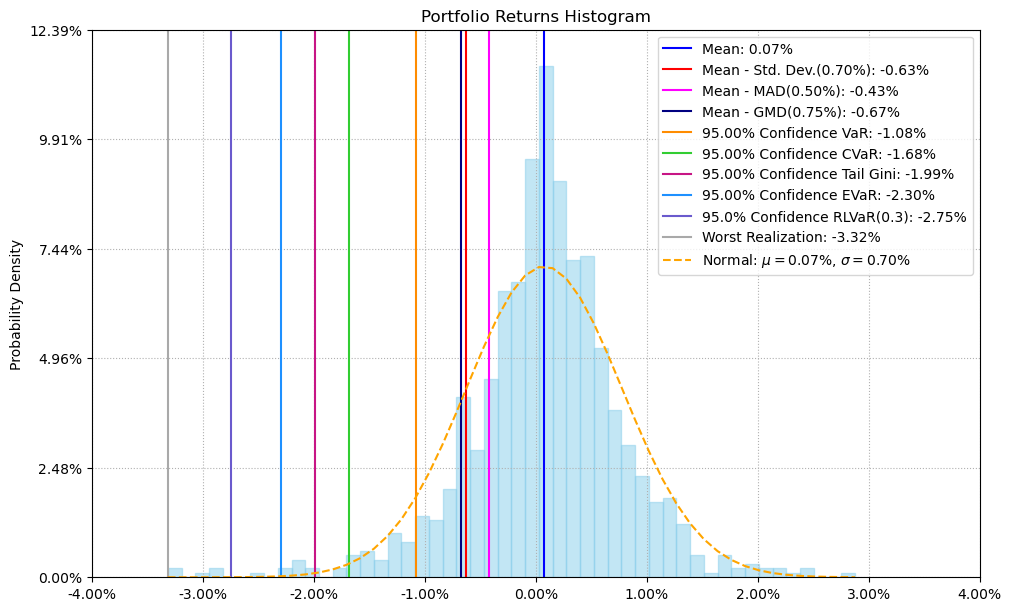

In [6]:
ax = rp.plot_hist(returns=Y,
                  w=w,
                  alpha=0.05,
                  bins=50,
                  height=6,
                  width=10,
                  ax=None)

### 2.4 Calculate efficient frontier

In [7]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters


,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
0,0.0000%,0.0000%,0.0000%,5.0943%,2.1190%,9.1724%,5.9399%,0.0000%,0.0000%,4.6364%,...,11.6040%,0.0000%,16.8051%,0.0000%,9.9307%,5.0339%,0.0000%,0.0000%,12.0237%,1.1935%
1,0.0000%,0.0000%,1.6621%,1.9614%,1.9982%,11.7341%,4.2346%,0.0000%,0.0000%,2.6813%,...,13.1191%,0.0000%,11.7940%,0.0000%,8.6353%,5.8336%,0.0000%,0.0000%,12.8240%,1.0369%
2,0.0000%,0.2319%,5.0771%,0.0000%,1.7003%,13.5303%,2.8151%,0.0000%,0.0000%,0.9686%,...,14.1948%,0.0000%,7.4511%,0.0000%,7.5693%,6.3544%,0.0000%,0.0000%,13.3875%,0.8414%
3,0.0000%,1.5969%,7.3179%,0.0000%,0.9663%,14.6744%,1.2945%,0.0001%,0.0000%,0.0000%,...,14.8985%,0.0000%,2.8334%,0.0000%,6.2117%,6.6908%,0.0000%,0.0000%,13.5405%,0.2279%
4,0.0000%,2.7856%,9.1115%,0.0000%,0.0000%,15.3398%,0.0000%,0.4397%,0.0000%,0.0000%,...,15.2871%,0.0000%,0.0000%,0.0000%,4.3598%,6.9393%,0.0000%,0.0000%,13.2193%,0.0000%


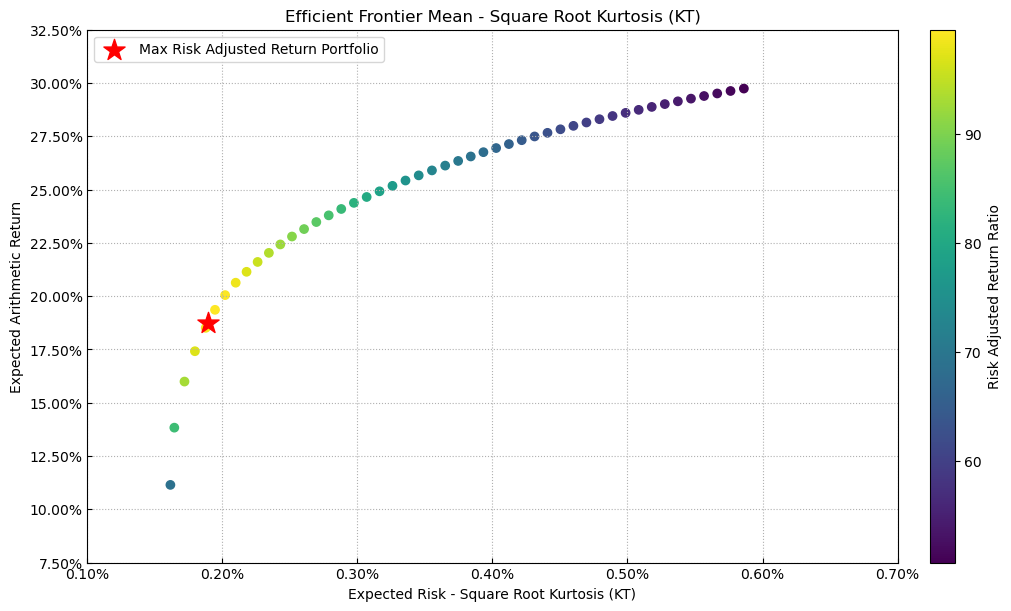

In [8]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier,
                      mu=mu,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=rf,
                      alpha=0.05,
                      cmap='viridis',
                      w=w,
                      label=label,
                      marker='*',
                      s=16,
                      c='r',
                      height=6,
                      width=10,
                      ax=None)

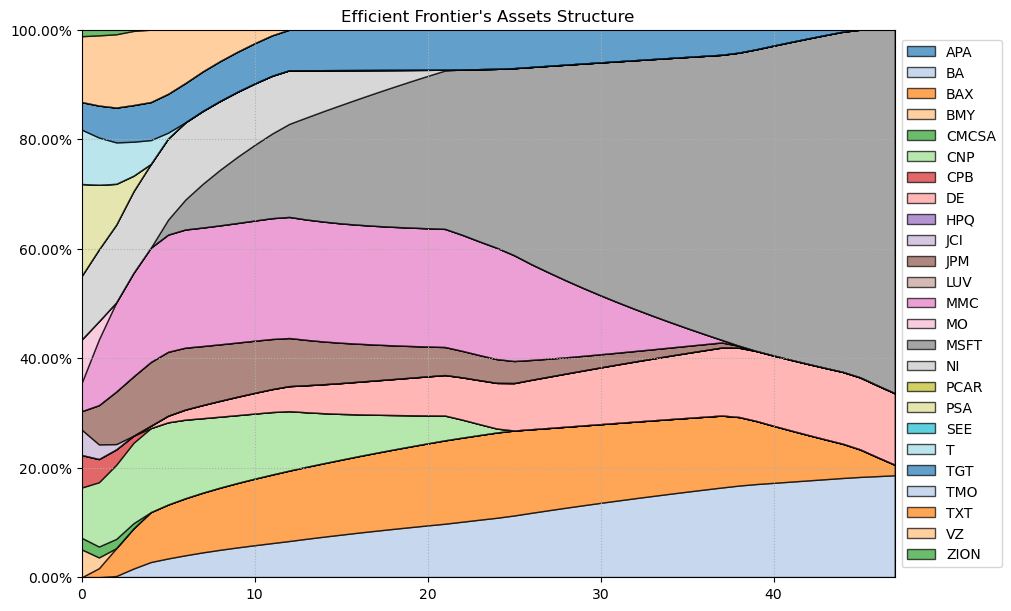

In [9]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier,
                           cmap="tab20",
                           height=6,
                           width=10,
                           ax=None)